## Install dependencies

First, we need to install the required dependencies for this project:

In [ ]:
!pip install git+https://github.com/autodistill/autodistill-grounded-sam-2 rf_groundingdino -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 519.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00


## Collect data

For this project, we need a folder of unlabeled images. We will label these images with Grounded SAM 2, then use them to train a model.

For this guide, we will use a dataset of shipping containers. We will use the dataset to train a model that can identify shipping containers.

In [ ]:
!wget https://media.roboflow.com/containers.zip
!unzip containers.zip

--2024-08-18 12:29:08--  https://media.roboflow.com/containers.zip
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12356763 (12M) [application/zip]
Saving to: ‘containers.zip’

containers.zip      100%[===================>]  11.78M  --.-KB/s    in 0.1s    

2024-08-18 12:29:08 (89.9 MB/s) - ‘containers.zip’ saved [12356763/12356763]

Archive:  containers.zip
   creating: containers/
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-75_jpg.rf.ffbb8716eb886f91e3a561e2ba4be074.jpg  
  inflating: containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-169_jpg.rf.c0bf90f4b4bf5450508f6ccd5fd85e79.jpg  
  inflating: __MACOSX/containers/._Tips-and-tricks-on-how-to-park-a-ya

## Load Grounded SAM 2

With a dataset ready, we can load Grounded SAM 2.

We need to provide an ontology for Grounded SAM 2. This refers to the objects that we want to identify, and the labels that we want to use in our dataset.

An ontology uses the following structure:

```
{"prompt": "label"}
```

For example, the following ontology will send the prompt "shipping container" to a model and save the results with the label "container":

```
{"shipping container": "container"}
```

In [ ]:
from autodistill_grounded_sam_2 import GroundedSAM2

Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.


In [ ]:
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import numpy as np
import cv2
import os
import random
import supervision as sv

# define an ontology to map class names to our Grounded SAM 2 prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "shipping container": "container"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Test the model

Now that we have loaded the model, we can test it on images. Let's test on random images in the `containers` directory we downloaded earlier. If you are using your own dataset, replace the value of `IMAGE_DIR` with the folder where your unlabeled images are stored.

torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


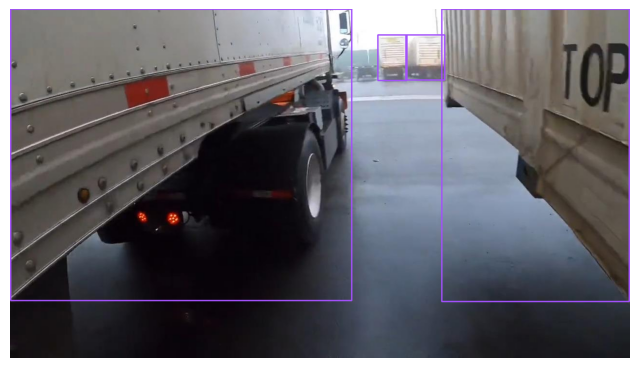

In [ ]:
IMAGE_DIR = "containers"
IMAGE_PATH = os.path.join(IMAGE_DIR, random.choice(os.listdir(IMAGE_DIR)))

results = base_model.predict(IMAGE_PATH).with_nms()
results = results[results.confidence > 0.3]

image = cv2.imread(IMAGE_PATH)

mask_annotator = sv.BoxAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

If your prompt does not work well, update your ontology to use a new prompt.

It may take a few tries to find a prompt that works.

Note that Grounding DINO, on which Grounded SAM 2 depends for object identification, cannot identify all objects. If, after experimentation, you cannot get the model to identify objects of interest, this model may not be suited to your task.

## Label the dataset

Once you have found a prompt that works for your dataset, you can label your dataset like so:

In [ ]:
base_model.label(IMAGE_DIR, extension="jpg")

Labeling containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-168_jpg.rf.e6fb8ccf37f8fb4e8a89085c24d43588.jpg: 100%|██████████| 156/156 [02:51<00:00,  1.10s/it]
Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


Labeled dataset created - ready for distillation.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install roboflow
!pip install pyresearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.0/869.0 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


With a labeled dataset ready, the next step is to inspect the quality of the labels and train your model. Roboflow has utilities for both of these steps. With Roboflow, you can review and amend annotations, then use your dataset to train a model.

[Create a free Roboflow account](https://roboflow.com), then create a new project in your Roboflow dashboard. Once you have a new project, you can upload your labeled data to the platform with the following code:

In [ ]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

workspace = rf.workspace("capjamesg")
workspace.upload_dataset(
    IMAGE_DIR + "_labeled/",
    "shipping-containers-kktus",
    project_license="MIT",
    project_type="object-detection",
)

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Uploading to existing project capjamesg/shipping-containers-kktus
[ERR] containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-10_jpg.rf.75a5875a4b8b4f8ce500dd53cf899d11.jpg (Error uploading image: {'error': {'message': 'Unsupported request. `POST /dataset/shipping-containers-kktus/upload` does not exist or cannot be loaded due to missing permissions.', 'type': 'GraphMethodException', 'hint': 'You can see your active workspace by issuing a GET request to `/` with your `api_key`.'}})
[ERR] containers_labeled/train/images/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-12_jpg.rf.a897624f269bc94acbad8e666a403e6c.jpg (Error uploading image: {'error': {'message': 'Unsupported request. `POST /dataset/shipping-containers-kktus/upload` does not exist or cannot be loaded due to missing per

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install ultralytics

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=containers_labeled/data.yaml epochs=50 imgsz=600 plots=True

100% 21.5M/21.5M [00:00<00:00, 143MB/s] 
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=containers_labeled/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=600, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal